# Milestone project 2 - SkimLit

## SkimLit sequece problem: Many to one

To investigate the efficacy of @week of daily low-dose oral prednisolone in improving pain, mobility, systemic low-grade inflamation in the short term and wether the effect would be sustained at @week in order adults with moderate to sever knee osteoarthritis (OA).

## What we're going to cover

* Download a text dataset (PubMed 200k RCT)
* Writing a preprocessing function for our text data
* Setting up multiple modelling experiments with differents levels of embeddings
* Building a multimodal model to take in different source of data
    - Replicating the model powering https://arxiv.org/abs/1710.06071
* Finding the most wrong prediction example

see: https://www.nltk.org/install.html


In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 Ti (UUID: GPU-396e0d2a-a22a-a57f-bd25-8f6297e10119)


## Get dataset

Since we'll be replicating a paper above (PubMed 200k RCT), let's download the data they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
import os
import sys
import shutil
import random
import string
import re
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import nltk
import multiprocessing

from keras.utils import plot_model
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer



# add path root project to read helper fuctions
sys.path.append(os.path.join('../'))

from helper_functions import calculate_results

print(f'pandas: {pd.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'sklearn: {skl.__version__}')

pandas: 1.3.5
tensorflow: 2.9.3
sklearn: 1.0.2


In [3]:
nltk_lists = ['tokenizers/punkt', 'stemmers/rslp', 'corpora/stopwords']

for name in nltk_lists:
    try:
        nltk.data.find(name)
    except LookupError:
        nltk.download(name.split('/')[1])

In [4]:
STORAGE = os.path.join('../../', 'storage')
MODEL_PATH = f'{STORAGE}/models'
NLP = f'{STORAGE}/nlp'

In [5]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# shutil.move('pubmed-rct', f'{NLP}')

In [6]:
# list dir and see your content
os.listdir(f'{NLP}/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign')

['dev.txt', 'test.txt', 'train.txt']

In [7]:
# start our experiments using 20k dataset with number replaced by '@' sign
data_dir = f'{NLP}/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [8]:
# check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['../../storage/nlp/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '../../storage/nlp/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '../../storage/nlp/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, Visualize, Visualize

So with that in mind, let's write a function to read in all of the lines of a target text file


In [9]:
# create a function to read the lines of a document
def get_lines(filename):
    """ 
    Reads filename (a txt filename) and returns the lines of a text as a list
    Args:
        filename:  a string  containing the target filepath
    Returns:
        A list of strings with one string per line from the target filename
    """
    with open(filename, 'r') as file:
        return file.readlines()

In [10]:
# Let's read in the training lines

train_lines = get_lines(data_dir + 'train.txt') # read the lines with the training file
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

How I think our data would be best represented

```json
[   
    {
        "line_number":0,
        "target": "BACKGROUND",
        "text":" 'Serum levels of interleukin @ ( IL-@ ) , IL-@  and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n'",
        "total_lines": 11
    }
]

```

Let's write a function which turns each of our dataset into the above format so we can continue to prepare

In [11]:
def preprocess_text_with_line_numbers(filename):
    """ 
    Args:
        filename: (str) required
    Returns:
        A list of dictionaries of abstract line data.

        Takes in filename, reads it contents and sorts through each line, extracting
        things like the target label, the text of the sentence, how many sentences are
        in the current abstract and what sentence number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_sample = [] # create an empty list

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check if line start with ###
            # get id from line
            abstract_id = line

            # reset the abstract string if the line is an ID line
            abstract_lines = "" 
        elif line.isspace(): # check line is a new line
            # split abstract into separate lines
            abstract_line_split = abstract_lines.splitlines()

            # iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                # create an empty dictionary for each line
                line_data = {}
                
                # split target label from text
                target_text_split = abstract_line.split('\t')
                
                # get target label
                line_data['target'] = target_text_split[0]
                
                # get target text and lower it
                line_data['text'] = target_text_split[1].lower()
                
                # what number does the line appear in
                line_data['number'] = abstract_line_number
                
                # how many total lines are there in the target abstract? (start from 0)
                line_data['total_line'] = len(abstract_line_split) - 1
                
                # add line data to abstract sample list
                abstract_sample.append(line_data)
        else: # if the above conditions aren't fulfilled the line contains a labelled sentences 
            abstract_lines += line
            
    return abstract_sample
    

In [12]:
# get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name for validation data
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [13]:
# check the first abstract of our training data
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'number': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'number': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'number': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'number': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario and mcmaster universit

Use pandas to visualize our train_samples

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
# how are distribution of labels in training data
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

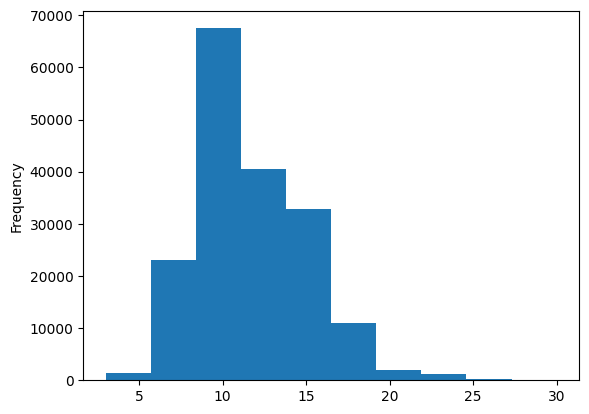

In [17]:
# let's check the length of different lines
train_df['total_line'].plot.hist()

In [18]:
# convert abstract text line to list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make numeric label (ML models require numeric label)

see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

see: https://en.wikipedia.org/wiki/Sparse_matrix

**WARNING**: Tensorflow is uncompatible with matrix sparse so use hyperameter false in OneHotEncoder of sklearn preprocessing

In [20]:
# one hot encoder
one_hot_encoder = skl.preprocessing.OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what trainining one hot encoder look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoder

In [21]:
# Extract labels ('target' column) and encode them into integers
label_encoder = skl.preprocessing.LabelEncoder()
train_labels_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_label_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training label look like
train_labels_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# get class name and number of classes from LabelEncoder intances
num_classes = len(label_encoder.classes_)
class_names =  label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline

In [23]:
# create model 0 baseline
model_0 = Pipeline([ 
    ('tf-idf', TfidfVectorizer()),  # convert words to number using tf-idf
    ('clf', MultinomialNB()) # model text
])

model_0_history = model_0.fit(train_sentences, train_labels_label_encoded)

In [24]:
model_0.score(val_sentences, val_labels_label_encoded)

0.7218323844829869

In [25]:
# make some predictions using our baseline
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
model_0_results = calculate_results(y_true=val_labels_label_encoded, y_pred=model_0_preds)
model_results = pd.DataFrame({'model_0_results': model_0_results})
model_results.transpose()

,accuracy,f1,precision,recall
model_0_results,0.721832,0.698925,0.718647,0.721832


## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [27]:
# how many words there are in our train_sentences: https://arxiv.org/pdf/1710.06071.pdf
sent_lens = [len(sentence.split()) for sentence in train_sentences]
len(sent_lens)

180040

In [28]:
# how long is each sentence on average?
np.mean(sent_lens)

26.338269273494777

In [29]:
# how long is each sentence on average?
sum(sent_lens)/len(train_sentences)

26.338269273494777

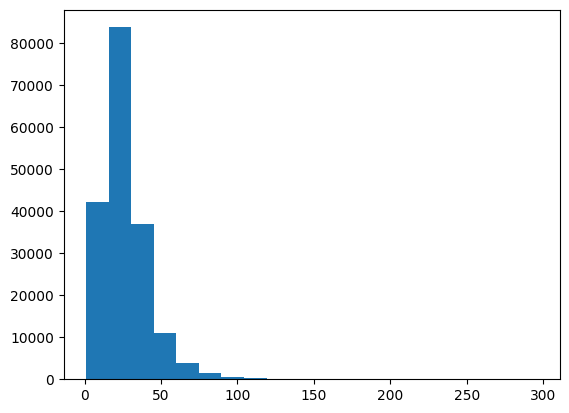

In [30]:
# What's the distribuition look like?
ax = plt.hist(sent_lens, bins=20)

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set
max(sent_lens)

296

In [33]:
max_tokens = 68000

# create text vectorizer
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                                                               output_sequence_length=output_seq_len,
                                                                               )

In [34]:
# adapt text vecotorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorizer text: {text_vectorizer([target_sentence])}')
print(f'\nLength Vectorizer: {len(text_vectorizer([target_sentence])[0])}')

Text:
a total of @ children ( aged @-@ years ) were randomized by school classes into a monitoring vs no-monitoring group .

Length of text: 22

Vectorizer text: [[    8    76     4   109   307    64     9    29    22   846  2475   143
      8   607    44 29822    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Length Vectorizer: 55


In [36]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'The most common words: {rct_20k_text_vocab[:5]}')
print(f'The least common words: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
The most common words: ['', '[UNK]', 'the', 'and', 'of']
The least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# get the config of text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [38]:
# create token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                                        output_dim=128, # NOTE: different embedding sizes result in 
                                        mask_zero=False, # use masking to handle variable sequence length
                                        name='token_embedding'
                                        )

In [39]:
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Sentence after embedding shape:\n{embedded_sentence.shape}')

Sentence before vectorization:
 a total of @ children ( aged @-@ years ) were randomized by school classes into a monitoring vs no-monitoring group .

Sentence after vectorization (before embedding):
[[    8    76     4   109   307    64     9    29    22   846  2475   143
      8   607    44 29822    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04731191  0.01687222  0.00011636 ... -0.01576472 -0.01419325
   -0.03374523]
  [ 0.04471033  0.00787769 -0.03810167 ... -0.02677356  0.00886334
    0.00834662]
  [-0.00295116  0.01351228 -0.03054488 ...  0.04002272 -0.00724564
    0.01006081]
  ...
  [ 0.04661373  0.01173985  0.00409436 ... -0.02789465  0.02204971
   -0.02520366]
  [ 0.04661373  0.01173985  0.00409436 ... -0.02789465  0.02204971
   -0.02520366]
  [ 0.0466

In [40]:
# Turn our data into Tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
# Take the TensorSliceDataset's and turn them into prefected dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE),

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [42]:
# create Conv 1D model to process sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) # vectorize text input
x = token_embed(x) # create embedding
x = tf.keras.layers.Conv1D(filters=64, 
                           kernel_size=5, 
                           padding='same', 
                           activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = tf.keras.layers.Dense(num_classes, 
                                activation='softmax')(x) # we have more than two class
model_1 = tf.keras.Model(inputs, 
                         outputs,
                         name='model_1_conv1d_token_embedding')

# compile mode 1
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# show summary
model_1.summary()

Model: "model_1_conv1d_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 

In [43]:
# fit the model with 10% of train_dataset
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # use only 10%
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)) # only validate on 10% of batches
                              )

Epoch 1/3
562/562 [==============================] - 14s 10ms/step - loss: 0.9156 - accuracy: 0.6347 - val_loss: 0.6883 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6605 - accuracy: 0.7543 - val_loss: 0.6346 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6199 - accuracy: 0.7738 - val_loss: 0.5973 - val_accuracy: 0.7872


In [44]:
# evaluate the model
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5995 - accuracy: 0.7861


[0.599485456943512, 0.7860783934593201]

In [45]:
# make some predictions (out model predictions probabilities for each class)
model_1_pred_prob = model_1.predict(val_dataset)
model_1_pred_prob

945/945 [==============================] - 2s 2ms/step


array([[4.2705047e-01, 1.8563825e-01, 8.4922038e-02, 2.7497214e-01,
        2.7417131e-02],
       [4.4584513e-01, 2.9473534e-01, 1.3887726e-02, 2.3644967e-01,
        9.0822279e-03],
       [1.3557127e-01, 6.4952979e-03, 1.9455823e-03, 8.5593873e-01,
        4.9037430e-05],
       ...,
       [2.4784163e-06, 7.2982803e-04, 6.0917629e-04, 1.8711119e-06,
        9.9865663e-01],
       [5.3473156e-02, 4.7392499e-01, 9.8630227e-02, 6.0885809e-02,
        3.1308582e-01],
       [1.9815038e-01, 6.1452579e-01, 4.3434050e-02, 5.6502126e-02,
        8.7387584e-02]], dtype=float32)

In [46]:
# convert to pred prob to classes
model_1_preds = tf.argmax(model_1_pred_prob, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [47]:
model_1_results = calculate_results(y_true=val_labels_label_encoded, y_pred=model_1_preds)

model_results = pd.DataFrame({'model_0_results': model_0_results,
                              'model_1_results': model_1_results})
model_results.transpose()

,accuracy,precision,recall,f1
model_0_results,0.721832,0.718647,0.721832,0.698925
model_1_results,0.786078,0.782613,0.786078,0.783555


## Model 2: Feature Extraction with Pretrained Model

see: https://keras.io/examples/nlp/pretrained_word_embeddings/

see: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

see: https://www.kaggle.com/code/chewzy/tutorial-how-to-train-your-custom-word-embedding

In [48]:
# model_use = tf.keras.models.load_model(f'{MODEL_PATH}/tfhub_universal_sentence_encoder')

tfhub_url = 'https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2'

# create a Keras Layer using the pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(tfhub_url, 
                                        input_shape=[], 
                                        dtype=tf.string,
                                        trainable=False, 
                                        name='USE')

In [49]:
# Test out the pretrained embedding on a random sentences
random_train_sentence = random.choice(train_sentences)
print(f'Random sentences:\n{random_train_sentence}')
use_embedding_sentence = sentence_encoder_layer([random_train_sentence])

Random sentences:
over the @-month period , no statistically significant associations between changes in the cfq subscale scores and changes in child bmi percentile were identified .


In [50]:
use_embedding_sentence

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-4.94096801e-02,  7.72148371e-02, -5.11406176e-02,
         2.58385390e-02, -5.07891141e-02, -1.35742165e-02,
        -4.01241034e-02,  3.12288268e-03,  1.35373464e-03,
         8.20486471e-02,  6.88035265e-02, -3.17996033e-02,
        -3.14729055e-03,  5.28822429e-02, -3.67323086e-02,
        -9.14945360e-03, -8.57649073e-02,  1.08646648e-02,
         2.59892214e-02, -2.55062152e-03, -2.26722080e-02,
         6.59973919e-02, -1.89125407e-02,  2.80961953e-03,
         1.63896810e-02,  3.94039936e-02,  1.29706059e-02,
         7.39498287e-02, -2.48467103e-02, -5.05347289e-02,
        -3.18851136e-02,  3.28513421e-02,  4.64073680e-02,
        -1.86683964e-02, -6.40047267e-02, -1.94110051e-02,
        -8.70724022e-02, -4.09874059e-02, -3.68115306e-02,
         4.75370400e-02, -4.55615707e-02,  6.61521330e-02,
        -6.32053092e-02, -6.22480689e-03,  4.12250422e-02,
        -3.78302578e-03,  6.58289436e-03, -6.77959472e-02,
      

In [51]:
# building a model and fitting an NLP feature extraction from tensorflow hub
inputs = tf.keras.layers.Input(shape=(), 
                               dtype=tf.string)
x = sentence_encoder_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = tf.keras.layers.Dense(128, 
                          activation='relu')(x)
# if you could add more layers here if you wanted to
outputs = tf.keras.layers.Dense(num_classes, 
                                activation='softmax')(x)
model_2 = tf.keras.Model(inputs, 
                         outputs, 
                         name='model_2_use_feature_extractor')
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9171 - accuracy: 0.6492 - val_loss: 0.7974 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7681 - accuracy: 0.7024 - val_loss: 0.7556 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7509 - accuracy: 0.7133 - val_loss: 0.7382 - val_accuracy: 0.7141


In [53]:
model_2.evaluate(val_dataset)

  5/945 [..............................] - ETA: 13s - loss: 0.8135 - accuracy: 0.6438

945/945 [==============================] - 12s 13ms/step - loss: 0.7396 - accuracy: 0.7153


[0.7395992875099182, 0.715278685092926]

In [54]:
model_2_pred_prob = model_2.predict(val_dataset)

945/945 [==============================] - 12s 13ms/step


In [55]:
# convert to pred prob to classes
model_2_preds = tf.argmax(model_2_pred_prob, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [56]:
model_2_results = calculate_results(y_true=val_labels_label_encoded, y_pred=model_2_preds)

model_results = pd.DataFrame({'model_0_results': model_0_results,
                              'model_1_results': model_1_results,
                              'model_2_results': model_2_results})
model_results.transpose()

,accuracy,precision,recall,f1
model_0_results,0.721832,0.718647,0.721832,0.698925
model_1_results,0.786078,0.782613,0.786078,0.783555
model_2_results,0.715279,0.716140,0.715279,0.712069


## Model 3: Conv1D with character embeending

The paper  which we're replicationg states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll nedd to do similar steps for characters if we want to use char-level embeddings.

see: https://medium.com/@WojtekFulmyk/text-tokenization-and-vectorization-in-nlp-ac5e3eb35b85

see: https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-feature-vectors


In [57]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [58]:
# make functions to split sentences into characters
def split_chars(text:str):
    return ' '.join(list(text))

In [59]:
def custom_preprocessor(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [60]:
# text splitting no-character-level sequence into characteres
split_chars(random_train_sentence)

'o v e r   t h e   @ - m o n t h   p e r i o d   ,   n o   s t a t i s t i c a l l y   s i g n i f i c a n t   a s s o c i a t i o n s   b e t w e e n   c h a n g e s   i n   t h e   c f q   s u b s c a l e   s c o r e s   a n d   c h a n g e s   i n   c h i l d   b m i   p e r c e n t i l e   w e r e   i d e n t i f i e d   .'

In [61]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# what's the average character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_chars_lens = np.mean(chars_lens)
mean_chars_lens

149.3662574983337

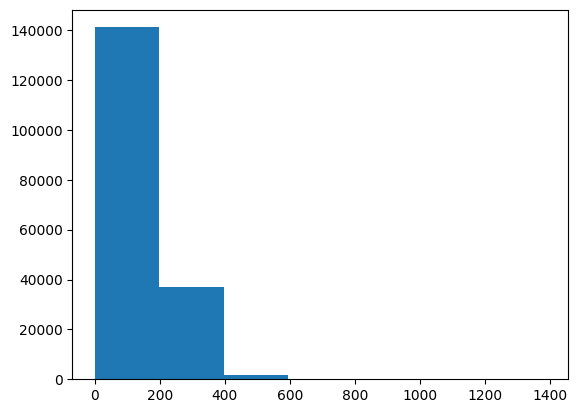

In [63]:
# check the distribution of our sequences at a character-level
ax = plt.hist(chars_lens, bins=7)

In [64]:
# find what character length cover 95% of sequence
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [65]:
# get all character
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=output_seq_char_len,
                                                    # standardize='lower_and_strip_punctuation', # set to None if want to leave punctuation in
                                                    name='char_vectorizer')

In [67]:
tf_idf_vectorizer = TfidfVectorizer(analyzer='char',
                                    ngram_range=(2, 2), 
                                    strip_accents='ascii',
                                    max_features=output_seq_char_len).fit(train_chars)

In [68]:
tf_idf_vectorizer.get_feature_names_out()[:5]

array([' !', ' "', ' #', ' $', ' %'], dtype=object)

In [69]:
choice = random.choice(train_chars)
x = tf_idf_vectorizer.transform([choice]).toarray()
x

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0357378 , 0.        , 0.02116491, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03526898, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.25570156, 0.05793393, 0.0664513 ,
        0.02184231, 0.38350761, 0.        , 0.02538523, 0.09256502,
        0.256239  , 0.        , 0.        , 0.06685682, 0.07097246,
        0.12799004, 0.1287237 , 0.13948263, 0.        , 0.23444127,
        0.10682735, 0.23372357, 0.07040048, 0.05558978, 0.07718099,
        0.        , 0.05345986, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0357371 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [70]:
# World level unigrams and bigrams
count_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'),
                                   preprocessor=custom_preprocessor, 
                                   ngram_range=(1,2),
                                   min_df=2,
                                   max_df=0.8)
count_vectorizer.fit(train_sentences)

CountVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2),
                preprocessor=<function custom_preprocessor at 0x000001FCC1F61D08>,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [71]:
list(count_vectorizer.vocabulary_)[:5]

['investigate', 'efficacy', 'weeks', 'daily', 'low']

In [72]:
# character level bigrams
count_vectorizer = CountVectorizer(preprocessor=custom_preprocessor,
                                   stop_words=nltk.corpus.stopwords.words('english'),
                                   ngram_range=(2,2),
                                   max_features=output_seq_char_len,
                                   strip_accents='ascii',
                                   analyzer='char_wb')

In [73]:
train_vectors = count_vectorizer.fit_transform([random.choice(train_chars)])
train_vectors.toarray()

array([[12,  3,  9,  8, 23,  6,  1,  3, 12,  1,  8,  6, 11, 17,  4, 10,
        11, 15,  7,  3,  2,  3,  1, 12,  3,  9,  8, 23,  6,  1,  3, 12,
         1,  8,  6, 11, 17,  4, 10, 11, 15,  7,  3,  2,  3,  1]],
      dtype=int64)

In [74]:
# adapt character vectorizer to training
char_vectorizer.adapt(train_chars)
# test_vectors = count_vectorizer.transform(train_chars)

In [75]:
# check vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common char: {char_vocab[:5]}')
print(f'5 lear common char: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common char: ['', '[UNK]', 'e', 't', 'i']
5 lear common char: ['k', 'x', 'z', 'q', 'j']


In [76]:
print(f'Number of different characters in character vocab: {len(list(count_vectorizer.vocabulary_))}')
print(f'5 most common char: {list(count_vectorizer.vocabulary_)[:5]}')
print(f'5 lear common char: {list(count_vectorizer.vocabulary_)[-5:]}')

Number of different characters in character vocab: 46
5 most common char: [' t', 't ', ' h', 'h ', ' e']
5 lear common char: ['w ', ' y', 'y ', ' g', 'g ']


In [77]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of character: {len(random_train_chars.split())}')

vectorized_chars = char_vectorizer([random_train_chars])
vectorized_chars_counter = count_vectorizer.fit_transform([random_train_chars])

print(f'\nVectorized Vector: {vectorized_chars}')
# print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')
print(f'\nShape of vectorized chars: {vectorized_chars.shape}')

Charified text:
t h e   p a r e n t   t r i a l   w a s   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   p l a c e b o - c o n t r o l l e d   ,   p a r a l l e l - g r o u p   t r i a l   d e s i g n e d   t o   t e s t   t h e   e f f e c t s   o f   c a d   s u p p l e m e n t a t i o n   (   @ , @   m g   o f   e l e m e n t a l   c a l c i u m   +   @   i u   o f   v i t a m i n   d @   d a i l y   )   v e r s u s   p l a c e b o   i n   p o s t m e n o p a u s a l   w o m e n   .

Length of character: 204

Vectorized Vector: [[ 3 13  2 14  5  8  2  6  3  3  8  4  5 12 20  5  9  5 10  7 16 22 12  2
  22 12  4  6 10  8  5  6 10  7 15  4 25  2 10 14 12  5 11  2 22  7 11  7
   6  3  8  7 12 12  2 10 14  5  8  5 12 12  2 12 18  8  7 16 14  3  8  4
   5 12 10  2  9  4 18  6  2 10  3  7  3  2  9  3  3 13  2  2 17 17  2 11
   3  9  7 17 11  5 10  9 16 14 14 12  2 15  2  6  3  5  3  4  7  6 15 18
   7 17  2 12  2 15  2  6  3  5 12 11  5 12 11  4 16 15  4 16  7 17 21  4
   3  

In [78]:
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of character: {len(random_train_chars.split())}')
vectorized_chars_counter = count_vectorizer.fit_transform([random_train_chars])

# https://stackoverflow.com/questions/12668027/good-ways-to-expand-a-numpy-ndarray
vectorized_chars_counter_array = np.hstack((vectorized_chars_counter.toarray()[0], 
                                            np.zeros(output_seq_char_len - len(vectorized_chars_counter.toarray()[0])))).reshape(1, -1)
print(f'\nVectorized Counter: {vectorized_chars_counter_array}')
# print(f'\nLength of vectorized chars: {vectorized_chars_counter.getnnz()}')
print(f'\nShape of vectorized chars: {vectorized_chars_counter_array.shape}')

Charified text:
t h e   p a r e n t   t r i a l   w a s   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   p l a c e b o - c o n t r o l l e d   ,   p a r a l l e l - g r o u p   t r i a l   d e s i g n e d   t o   t e s t   t h e   e f f e c t s   o f   c a d   s u p p l e m e n t a t i o n   (   @ , @   m g   o f   e l e m e n t a l   c a l c i u m   +   @   i u   o f   v i t a m i n   d @   d a i l y   )   v e r s u s   p l a c e b o   i n   p o s t m e n o p a u s a l   w o m e n   .

Length of character: 204

Vectorized Counter: [[18.  4.  7. 10. 22.  5.  3.  2. 12. 17.  8. 12. 15.  9.  8.  9. 15.  7.
   2.  2.  1.  1. 18.  4.  7. 10. 22.  5.  3.  2. 12. 17.  8. 12. 15.  9.
   8.  9. 15.  7.  2.  2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.

In [79]:
np.mean([len(char) for char in train_chars])

297.7325149966674

In [80]:
np.percentile([len(sentence) for sentence in train_sentences], 95.57)

297.27229999998235

In [81]:
len(char_vocab) # alphabet

28

In [82]:
char_embed_keras = tf.keras.layers.Embedding(input_dim=len(char_vocab), # size of vocabulary
                                             output_dim=25, # this is the size of the char embedding in the paper
                                             mask_zero=True,
                                             name='char_embed_keras')

In [83]:
print(f'Charified text:\n{random_train_chars}')

print(f'\nCharified text:{len(random_train_chars.split())}')
char_embed_keras_sample = char_embed_keras(char_vectorizer([random_train_chars]))

print(f'\nVectorized Vector: {char_embed_keras_sample}')
print(f'\nShape of vectorized chars: {char_embed_keras_sample.shape}')

Charified text:
t h e   p a r e n t   t r i a l   w a s   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   p l a c e b o - c o n t r o l l e d   ,   p a r a l l e l - g r o u p   t r i a l   d e s i g n e d   t o   t e s t   t h e   e f f e c t s   o f   c a d   s u p p l e m e n t a t i o n   (   @ , @   m g   o f   e l e m e n t a l   c a l c i u m   +   @   i u   o f   v i t a m i n   d @   d a i l y   )   v e r s u s   p l a c e b o   i n   p o s t m e n o p a u s a l   w o m e n   .

Charified text:204

Vectorized Vector: [[[-0.00695201 -0.01390503  0.00889816 ... -0.01239643 -0.01939439
    0.00485532]
  [ 0.00797755  0.03315431  0.00278876 ... -0.0131636  -0.02265452
    0.02500287]
  [ 0.0330998  -0.04677064  0.03289716 ... -0.03557215 -0.01017016
    0.01530406]
  ...
  [ 0.0192833   0.04792545  0.02350788 ...  0.01776116  0.01714993
   -0.00518112]
  [ 0.0192833   0.04792545  0.02350788 ...  0.01776116  0.01714993
   -0.00518112]
  [ 0.0192833   0.04792545  0.02350

see: https://towardsdatascience.com/word-embedding-techniques-word2vec-and-tf-idf-explained-c5d02e34d08

In [84]:
len(random_train_chars)

487

## Build Conv1D model and fit with character-level

In [85]:
# Make Conv1D on chars
inputs = tf.keras.layers.Input(shape=(1,), 
                               dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed_keras(x)
x = tf.keras.layers.Conv1D(filters=64, 
                           kernel_size=5, 
                           padding='same', 
                           activation='relu')(x)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(num_classes, 
                                activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name='model_3_conv1d_char_embedding')

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed_keras (Embedding  (None, 290, 25)          700       
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                     

In [86]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, 
                                                         train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, 
                                                       val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, 
                                                        test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
# fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 1.2893 - accuracy: 0.4694 - val_loss: 1.0574 - val_accuracy: 0.5781
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0758 - accuracy: 0.5597 - val_loss: 0.9635 - val_accuracy: 0.6017
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9987 - accuracy: 0.5953 - val_loss: 0.9007 - val_accuracy: 0.6466


In [88]:
model_3.evaluate(val_char_dataset)

  1/945 [..............................] - ETA: 14s - loss: 1.2559 - accuracy: 0.5000

945/945 [==============================] - 3s 4ms/step - loss: 0.9221 - accuracy: 0.6427


[0.922123372554779, 0.6426916718482971]

In [89]:
model_3_preds_prob = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_preds_prob, 
                          axis=1)

model_3_results = calculate_results(y_true=val_labels_label_encoded, 
                                    y_pred=model_3_preds)

model_results = pd.DataFrame({'model_0_results': model_0_results,
                              'model_1_results': model_1_results,
                              'model_2_results': model_2_results,
                              'model_3_results': model_3_results})

model_results.transpose().sort_values(by='accuracy', ascending=False)

945/945 [==============================] - 3s 3ms/step


,accuracy,precision,recall,f1
model_1_results,0.786078,0.782613,0.786078,0.783555
model_0_results,0.721832,0.718647,0.721832,0.698925
model_2_results,0.715279,0.716140,0.715279,0.712069
model_3_results,0.642692,0.637635,0.642692,0.631760


## Model 4: Combine pretrained token embedding + characteres (hydrid)

1. Create a token level embedding (similar model 1)
2. create a character-level (similar model 3)
3. Combine 1 & 2 model witch concatenate (layers.concatenate)
4. Build a series of output layers on top  of 3 similar
5. Construct a model which takes token and caracter-level sequences as input and produces sequence label probabilities as output

In [90]:
# 1. Setup token inputs/model
token_inputs =  tf.keras.layers.Input(shape=(), 
                                      dtype=tf.string, 
                                      name='token_input')

token_embeddings = sentence_encoder_layer(token_inputs)

token_output = tf.keras.layers.Dense(units=128, 
                                     activation='relu')(token_embeddings)

token_model = tf.keras.Model(token_inputs, token_output, name='token_model')

# 2. Setup character inputs/model
char_inputs = tf.keras.Input(shape=(1,),
                              dtype=tf.string,
                              name='char_input')

char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed_keras(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings) # bi-LSTM shown in figure 1 of https://arxiv.org/abs/1710.06071
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name='char_model')

# 3. Setup concatenate token and char inputs/model
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hydrid')([token_model.output, 
                                                                           char_model.output])

# 4. create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/abs/1710.06071
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, 
                                       activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.6)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token input/model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name='model_4_token_and_char_embeddings')

In [91]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

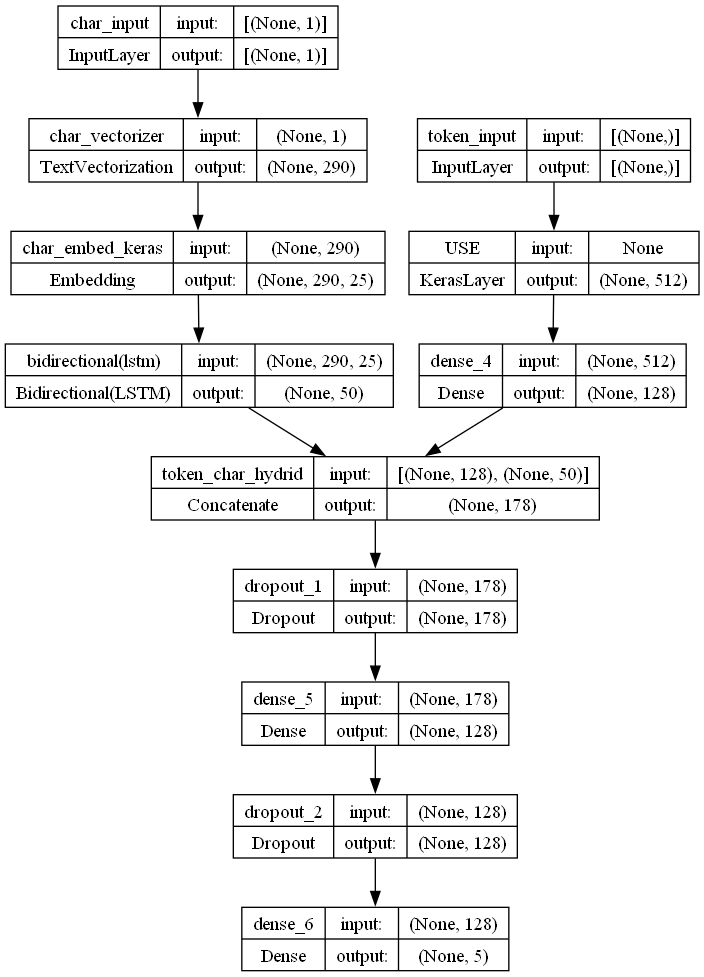

In [92]:
# plot the model
plot_model(model_4, show_shapes=True)

In [93]:
# compile the model
# model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

## Combining token and character data into tf.data dataset

see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [94]:
# combine chars and token
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combile data and labels
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # prefetch and batch dataset

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # prefetch and batch dataset

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # prefetch and batch dataset


train_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [95]:
# fit the model 4
# fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5


562/562 [==============================] - 52s 75ms/step - loss: 1.4934 - accuracy: 0.3551 - val_loss: 1.4443 - val_accuracy: 0.4378
Epoch 2/5
562/562 [==============================] - 38s 67ms/step - loss: 1.4347 - accuracy: 0.4021 - val_loss: 1.4001 - val_accuracy: 0.4894
Epoch 3/5
562/562 [==============================] - 34s 61ms/step - loss: 1.3925 - accuracy: 0.4410 - val_loss: 1.3319 - val_accuracy: 0.5110
Epoch 4/5
562/562 [==============================] - 39s 70ms/step - loss: 1.3190 - accuracy: 0.4715 - val_loss: 1.2389 - val_accuracy: 0.5180
Epoch 5/5
562/562 [==============================] - 36s 64ms/step - loss: 1.2468 - accuracy: 0.4893 - val_loss: 1.1457 - val_accuracy: 0.5332


In [96]:
model_4_preds_prob = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_preds_prob, 
                          axis=1)

model_4_results = calculate_results(y_true=val_labels_label_encoded, 
                                    y_pred=model_4_preds)

model_results = pd.DataFrame({'model_0_results': model_0_results,
                              'model_1_results': model_1_results,
                              'model_2_results': model_2_results,
                              'model_3_results': model_3_results,
                              'model_4_results': model_4_results})

model_results.transpose().sort_values(by='accuracy', ascending=False)

945/945 [==============================] - 31s 30ms/step


d:\projects\tensorflow_certificate\.tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1
model_1_results,0.786078,0.782613,0.786078,0.783555
model_0_results,0.721832,0.718647,0.721832,0.698925
model_2_results,0.715279,0.716140,0.715279,0.712069
model_3_results,0.642692,0.637635,0.642692,0.631760
model_4_results,0.541242,0.459700,0.541242,0.446563


# Model 5: Pretrained token embeddings + character embeddings + positional embeddings

## Feature Engineering
* Taking `non-obvious features` from the data and encoding them numerically to help our model learn
* How can we add extra sources of data to our model?

Data augmentation is a form of feature engineering

> **Note**: Any engineered features used to train a model need to be available at test time.  
> In our case, line numbers and total line are available.

## Create positional embeddings

In [97]:
# how many different line numbers are there?
train_df['number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: number, dtype: int64

In [98]:
train_df.head()

,target,text,number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<AxesSubplot:ylabel='Frequency'>

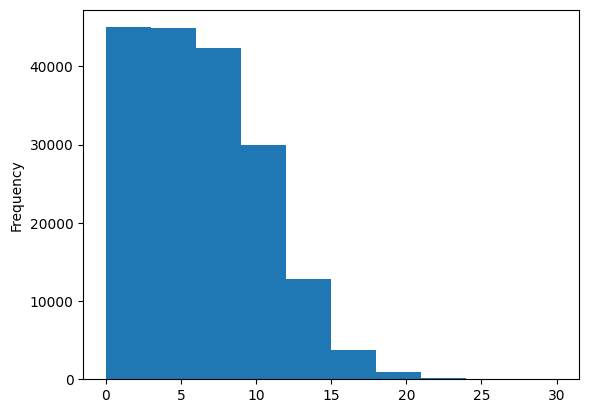

In [99]:
# check distribution of number
train_df.number.plot.hist()

In [137]:
# use tensorflow one-hot-encoder to create tensors of our number column
train_line_numbers_one_hot = tf.one_hot(train_df['number'].to_numpy(), depth=15) # depth=15 to prevent large dimension 
val_line_numbers_one_hot = tf.one_hot(val_df['number'].to_numpy(), depth=15) # depth=15 to prevent large dimension 
test_line_numbers_one_hot = tf.one_hot(test_df['number'].to_numpy(), depth=15) # depth=15 to prevent large dimension 

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature. let's do the same for our total lines

In [127]:
train_df['total_line'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_line, dtype: int64

<AxesSubplot:ylabel='Frequency'>

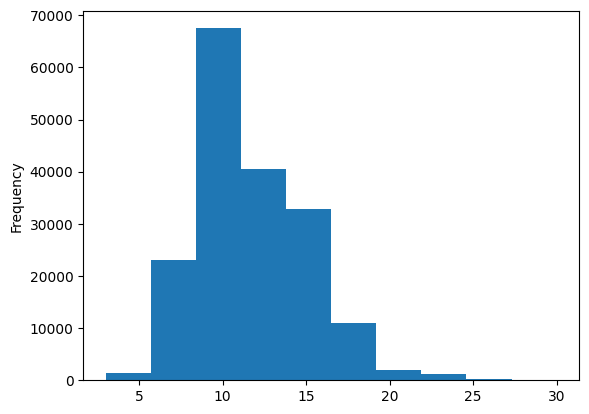

In [128]:
# check distribution of total lines

train_df['total_line'].plot.hist()

In [130]:
# check the coverage of a total lines
np.percentile(train_df.total_line, 98)

20.0

In [138]:
# use Tensorflow to create one-hot-encoder tensors of our total_line feature
train_total_line_one_hot = tf.one_hot(train_df.total_line.to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df.total_line.to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df.total_line.to_numpy(), depth=20)

train_total_line_one_hot.shape, train_total_line_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a tribrid embedding model

1. create a token-level model
2. create a character-level model
3. create a model for the line number feature
4. create a model for the total line feature
5. combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. create an output layer to accept the tribrided embedding and output label probabilities
8. combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [140]:
train_line_numbers_one_hot[0].shape, train_total_line_one_hot[0].shape

(TensorShape([15]), TensorShape([20]))

In [147]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=(), 
                                     dtype=tf.string, 
                                     name='token_input')

# 1.1 create token embedding with pretrained model
token_embeddings = sentence_encoder_layer(token_inputs) # transfer learning - pretrained model 

# 1.2 token output with activation relu
token_outputs = tf.keras.layers.Dense(units=128, 
                                      activation='relu')(token_embeddings)

# 1.3 create token model
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs,
                             name='token_model')

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), 
                                    dtype=tf.string, 
                                    name='char_input')
# 2.1 create a character vectorizer
char_vectors = char_vectorizer(char_inputs)

# 2.2 create a character embeddings with keras Embedding output_dim
char_embeddings = char_embed_keras(char_vectors)

# 2.3 create bidirectional layer with LSTM
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # bi-LSTM shown in figure 1 of https://arxiv.org/abs/1710.06071

# 2.3 create a char model
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name='char_model')

# 3. Line number model
line_number_inputs = tf.keras.layers.Input(shape=(15,), # train_line_numbers_one_hot[0].shape
                                           dtype=tf.float32,
                                           name='line_number_input')

# 3.1 create a dense layer with 32 units
line_number_outputs = tf.keras.layers.Dense(units=32,
                                            activation='relu')(line_number_inputs)

# 3.2 create a line model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs,
                                   name='line_number_model')
# 4. Total lines model
total_number_inputs = tf.keras.layers.Input(shape=(20,), # train_total_line_one_hot[0].shape
                                            dtype=tf.float32,
                                            name='total_number_input')

# 4.1 create a dense layer with 32 units and activation relu
total_number_outputs = tf.keras.layers.Dense(units=32,
                                             activation='relu')(total_number_inputs)

# 4.2 create a total model
total_number_model = tf.keras.Model(inputs=total_number_inputs,
                                    outputs=total_number_outputs,
                                    name='total_number_model')

# 5. combine token and char embeddings into hydrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name='char_token_hydrid_embedding')([token_model.output, 
                                                                                       char_model.output])
# 5.1 create a dense layer with 256 unis and activation relu
z = tf.keras.layers.Dense(units=256, 
                          activation='relu')(combined_embeddings)

# 5.2 create a Dropout layer with 0.5
z = tf.keras.layers.Dropout(0.5)(z)

# 6. combine positional embedding with conbinaed token and char embeddings
tribrid_embeddings = tf.keras.layers.Concatenate(name='char_token_possitional_embedding')([line_number_model.output,
                                                                                          total_number_model.output,
                                                                                          z])

# 7. create output layer 
output_layer = tf.keras.layers.Dense(units=num_classes,
                                     activation='softmax',
                                     name='output_layer')(tribrid_embeddings)

# 8. put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_number_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer,
                                 name='model_5_tribrid')

In [148]:
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]

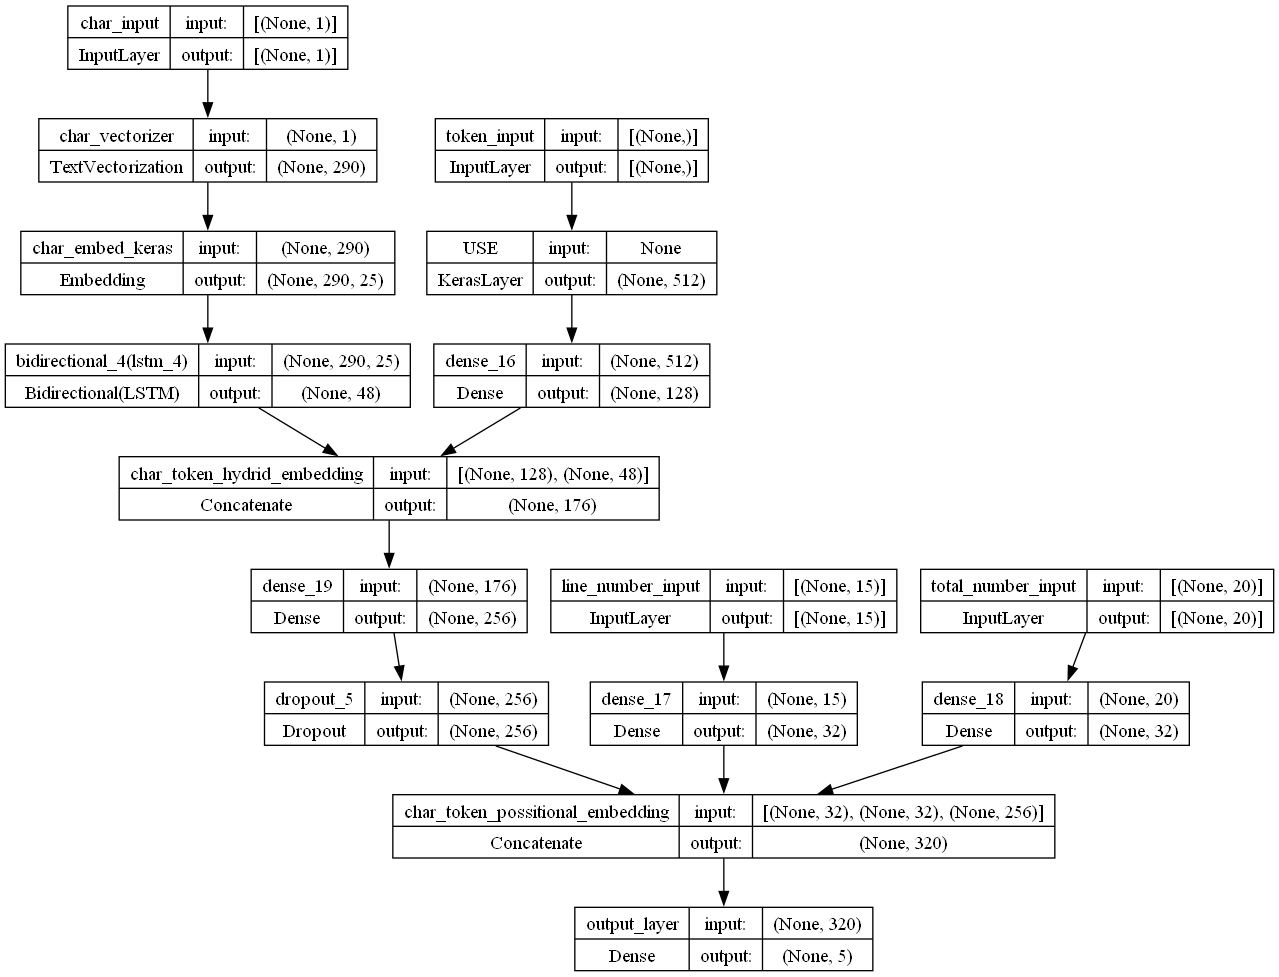

In [149]:
# plot model 5 to explore visualize
plot_model(model_5, show_shapes=True)

In [150]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
optimizer=tf.keras.optimizers.Adam(),
metrics=['accuracy'])

## Create tribrid embedding datasets using tf.data

In [101]:
cores = multiprocessing.cpu_count()
tf_idf_vectorizer = TfidfVectorizer(max_features=25)
vectorized_chars_counter = count_vectorizer.fit_transform([random_train_chars])
vectorized_chars_counter_array = np.hstack((vectorized_chars_counter.toarray()[0], 
                                            np.zeros(output_seq_char_len - len(vectorized_chars_counter.toarray()[0])))).reshape(1, -1)

vectorized_chars_counter_array

array([[18.,  4.,  7., 10., 22.,  5.,  3.,  2., 12., 17.,  8., 12., 15.,
         9.,  8.,  9., 15.,  7.,  2.,  2.,  1.,  1., 18.,  4.,  7., 10.,
        22.,  5.,  3.,  2., 12., 17.,  8., 12., 15.,  9.,  8.,  9., 15.,
         7.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [102]:
tf_idf_vectorizer = TfidfVectorizer(max_features=25,
                                    stop_words=nltk.corpus.stopwords.words('english'),
                                    strip_accents='ascii',
                                    analyzer='char_wb')
char_embed_tf_idf = tf_idf_vectorizer.fit_transform(np.hstack((random_train_chars.split(), 
                                                               np.zeros(output_seq_char_len - len(random_train_chars.split())))))

In [103]:
char_embed_tf_idf

<290x25 sparse matrix of type '<class 'numpy.float64'>'
	with 659 stored elements in Compressed Sparse Row format>

In [104]:
cores = multiprocessing.cpu_count()
vocabs = np.hstack((random_train_chars.split(),
                    np.zeros(output_seq_char_len - len(random_train_chars.split()))))
w2v_model = Word2Vec(min_count=4,
                     window=4,
                     vector_size=len(vocabs),
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     sg = 1,
                     workers=cores-1)
w2v_model.build_vocab(vocabs, progress_per=10000)
w2v_model.train(vocabs, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

(6023, 46200)

In [105]:
w2v_model.wv.vectors.shape

(20, 290)

In [106]:
# with open('D:/txt/cbow_s1000.txt', 'r', encoding='utf-8') as f:
#     lines = f.readlines()

In [107]:
# for line in lines[1:10]:
#     print(line.split())

In [108]:
# parser = argparse.ArgumentParser()
# parser.add_argument('input', help='Single embedding txt file')
# parser.add_argument('output', help='Output basename without extension')
# args = parser.parse_args()

# embedding_cbow_file = args.ouput + '.npy'
# vocabulary_cbow_file = args.output + '.txt'

# https://blog.ekbana.com/loading-glove-pre-trained-word-embedding-model-from-text-file-faster-5d3e8f2b8455
# https://gist.github.com/erickrf/e54cd0f3d917ec61b3ae758a5e47b883
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1
# https://github.com/deeplearning4j
# https://medium.com/@erkajalkumari/step-by-step-guide-to-word2vec-with-gensim-2c4cd9dde01f

# vocabs = []
# words_vector = []
# for line in lines[1:100]:
#     splitlines = line.split()
#     vocabs.append(splitlines[0].strip())
#     words_vector.append(np.fromiter((np.float32(x.replace(',', '.')) for x in splitlines[1:]), dtype=np.float32))

In [109]:
# np.save('D:/txt/cbow_1000.npy', np.array(words_vector))
# with open('D:/txt/cbow_1000.vocab', 'w', encoding='utf-8') as f:
#     for vocab in vocabs:
#         f.write(vocab)
#         f.write('\n')

In [110]:
def convert_to_binary(input_txt, output_vocab, output_binary):
    """
    :param input_txt - takes path of embedding which is in text format
    :param output_vocab - output vocabulary
    :param output_binary - output numpy array binary 
    :return a binary file Numpy .npy format
    """
    with open(input_txt, 'r', encoding='utf-8') as read_file:
        lines = read_file.readlines()
        word_vector = []
        with open(output_vocab, 'w', encoding='utf-8') as write_file:
            for line in lines[1:100]:
                splitlines = line.split()
                write_file.write(splitlines[0].strip().encode('utf-8'))
                write_file.write("\n")
                word_vector.append(np.fromiter((np.float32(x.replace(',', '.')) for x in splitlines[1:]), dtype=np.float32))
    np.save(output_binary, np.array(word_vector))

In [111]:
def load_embeddings_binary():
    """
    encoding='cp1252'
    It loads embedding provided by glove which is saved as binary file. Loading of this model is
    about  second faster than that of loading of txt glove file as model.
    :param embeddings_path: path of glove file.
    :return: glove model
    """
    model = {}

    with open('D:/txt/cbow_1000.vocab', 'r', encoding='utf-8') as file:
        words = [line.strip() for line in file]
    
    wv = np.load('D:/txt/cbow_1000.npy')
    
    for i, w in enumerate(words):
        model[w] = wv[i]
    
    return model

In [112]:
def build_phrases(sentences):
    phrases = Phrases(sentences,
                      min_count=5,
                      threshold=7,
                      progress_per=1000)
    return Phraser(phrases)

In [113]:
result = build_phrases(["hoje é bonito", "amanhã será feito"])

In [114]:
# dict_w2v = load_embeddings_binary()
# embedding_df = pd.DataFrame(dict_w2v)
# embedding_df

In [115]:
def get_w2v(sentence, model):
    """
    :param sentence: inputs a single sentences whose word embedding is to be extracted.
    :param model: inputs glove model.
    :return: returns numpy array containing word embedding of all words    in input sentence.
    """
    return np.array([model.get(val, np.zeros(1000)) for val in sentence.split()], dtype=np.float64)

In [116]:
w2v_sentences = ["oi me ferrei!"]
model_w2v = Word2Vec(sentences=[sentence.split() for sentence in w2v_sentences], 
                     vector_size=1000,
                     min_count=1)

In [117]:
model_w2v.build_vocab([sentence.split() for sentence in w2v_sentences])

In [118]:
model_w2v.wv.get_normed_vectors()

array([[ 0.01410555,  0.00464589, -0.01393688, ..., -0.04186802,
        -0.0317688 ,  0.00677336],
       [ 0.03794698, -0.00839328,  0.04254368, ...,  0.0391486 ,
         0.02925768,  0.04951321],
       [-0.00294314,  0.00129767,  0.02801025, ...,  0.03203147,
         0.05154461,  0.01924811]], dtype=float32)

In [119]:
model_w2v.wv.get_vector('ferrei!')

array([ 2.57017615e-04,  8.46529001e-05, -2.53944163e-04,  9.35766671e-04,
        2.75750877e-04,  4.09564731e-04, -1.18293523e-04,  9.04502886e-05,
        6.62430772e-04, -7.26501967e-05,  3.34150798e-04, -6.72020906e-05,
        5.24839619e-04,  3.63993400e-04,  2.58252869e-04, -5.30989433e-04,
       -4.70810162e-04,  4.30802116e-04, -5.90717071e-04, -1.80206298e-05,
       -6.33516320e-05,  3.49324226e-04, -8.44226626e-04,  8.81723419e-04,
       -1.44874575e-04, -5.33092709e-04,  4.05446772e-04, -1.93549160e-04,
       -7.76548404e-04, -4.49679850e-04, -3.87728214e-05, -8.94647383e-04,
        5.70561897e-05,  2.44179246e-04, -3.22527398e-04,  2.57040025e-04,
        2.48079770e-04,  9.98821459e-04,  1.43050434e-04,  2.02053780e-04,
        2.77956016e-04, -2.07787278e-04, -8.69861629e-04,  8.02317401e-04,
       -1.97469708e-04, -9.69231362e-04, -6.55200507e-04, -3.94586095e-04,
        3.95434618e-04,  5.03858086e-04,  6.08601084e-04, -6.77026052e-04,
        6.88836590e-05, -

In [120]:
model_w2v.wv.similar_by_vector(model_w2v.wv.get_vector('oi'))

[('oi', 1.0000001192092896),
 ('me', 0.026572521775960922),
 ('ferrei!', -0.022045189514756203)]

In [121]:
# w2v = KeyedVectors.load_word2vec_format('D:/txt/cbow_s1000.txt')

In [122]:
# w2v.add_vector("ferrei!", model_w2v.wv.get_vector('ferrei!'))

In [123]:
# [ [w2v.get_vector(w) for w in sentence.split()] for sentence in ["hoje é um bom dia"] ]

In [124]:
# dict_w2v.update({'ferrei!': model_w2v.wv.get_vector('ferrei!')})
# result = get_w2v("eu me ferrei!", dict_w2v)
# result.shape, result[2]

In [125]:
# convert_to_binary('D:/txt/cbow_s1000.txt', 'D:/txt/cbow_1000.vocab', 'D:/txt/cbow_1000.npy')